## Week 12 Homework (10)

### Q1: define

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)




**General Stochastic Process**: A collection of random variables indexed by time or space. $\{X_t\} t∈T$, where each $X_t$  is a random variable.

**Gaussian Process (GP)**: A stochastic process where any finite subset of variables has a joint Gaussian distribution.

Fully specified by:

*   Mean function: $m(x)=\text{E}[f(x)]$
*   Covariance function (kernel): $\text{k}(x,x')= \text{Cov}(f(x),f(x'))$

Denoted as: $f(x)~GP(m(x),k(x,x'))$

Usage: Non-parametric modeling of unknown functions in regression/classification with uncertainty quantification.

**Variational Inference (VI) and the Evidence Lower Bound (ELBO)**
**Goal**: Approximate the posterior $p(θ|y)$ with a simpler distribution $q(θ)∈Q$

**Method**: Minimize the KL divergence:

$\text{KL}(q(θ)∥p(θ|y))$

**ELBO Definition:**

$\text{ELBO}(q)=E_{q(θ)}[\text{log}p(y|θ)] - \text{KL}(q(θ)∥p(θ))$

Maximizing the ELBO ≈ minimizing KL divergence to the true posterior.

**Why use VI?**

Posterior is intractable? Use VI.

Faster than MCMC in many contexts.

Works well for high-dimensional or deep models (e.g. Bayesian NNs).

### Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.



In [3]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

In [4]:
import kagglehub

# Using at Heart Disease Dataset
# Download latest version
path = kagglehub.dataset_download("alexteboul/heart-disease-health-indicators-dataset")

print("Path to dataset files:", path)

# Load Dataset
data_path = "/root/.cache/kagglehub/datasets/alexteboul/heart-disease-health-indicators-dataset/versions/3/heart_disease_health_indicators_BRFSS2015.csv"
df = pd.read_csv(data_path)

# Use a random subset of 5000 samples
df_sample = df.sample(n=5000, random_state=42)

Path to dataset files: /root/.cache/kagglehub/datasets/alexteboul/heart-disease-health-indicators-dataset/versions/3


/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Output()

Output()

ValueError: x and y must have same first dimension, but have shapes (200,) and (500, 200)

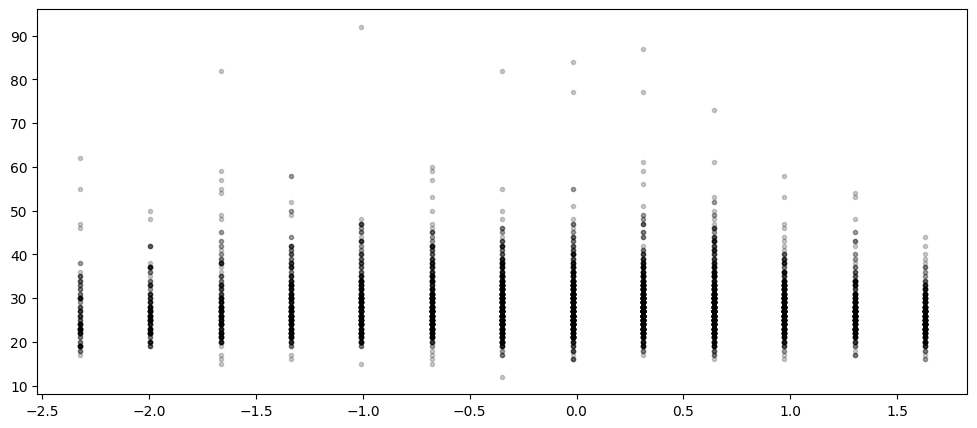

In [6]:
# Use Age as input (scaled), BMI as output

x = df_sample['Age'].values
y = df_sample['BMI'].values
x = (x - x.mean()) / x.std()


subset_idx = np.random.choice(len(x), size=300, replace=False)
x_small = x[subset_idx]
y_small = y[subset_idx]

# GP Regression
with pm.Model() as gp_model:
    l = pm.Gamma("l", alpha=2, beta=1)
    nu = pm.HalfNormal("η", sigma=5)
    cov = nu**2 * pm.gp.cov.ExpQuad(1, l)

    gp = pm.gp.Marginal(cov_func=cov)
    sigma = pm.HalfNormal("sigma", sigma=1)

    y_obs = gp.marginal_likelihood("y", X=x_small[:, None], y=y_small, noise=sigma)
    trace_gp = pm.sample(500, chains=2, return_inferencedata=True)

# Predict
Xnew = np.linspace(x.min(), x.max(), 200)[:, None]
with gp_model:
    y_pred = gp.conditional("y_pred", Xnew)
    pred_samples = pm.sample_posterior_predictive(trace_gp, var_names=["y_pred"], random_seed=42, return_inferencedata=False)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(x, y, "k.", alpha=0.2, label="Data")
plt.plot(Xnew.flatten(), pred_samples["y_pred"].mean(0), color="blue", label="GP Mean")
plt.fill_between(Xnew.flatten(),
                 np.percentile(pred_samples["y_pred"], 2.5, axis=0),
                 np.percentile(pred_samples["y_pred"], 97.5, axis=0),
                 alpha=0.3, label="95% CI")
plt.legend(); plt.title("GP Regression on Age vs BMI");

**Q2 Explaination**

We model:

$\text{BMI}_i ∼ N(f(x_i), σ^2)$

$f(x) \sim GP()0, k(x, x'))$

$k(x,x') = μ^2 exp(- \frac{(x-x')^2}{2l^2}$)

where $x_i$ is normalized age and the GP estimates the BMI distribution with uncertainty.

### Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.


In [7]:
import pytensor.tensor as pt

In [9]:
import kagglehub

# Using at Heart Disease Dataset
# Download latest version
path = kagglehub.dataset_download("alexteboul/heart-disease-health-indicators-dataset")

print("Path to dataset files:", path)

# Load Dataset
data_path = "/root/.cache/kagglehub/datasets/alexteboul/heart-disease-health-indicators-dataset/versions/3/heart_disease_health_indicators_BRFSS2015.csv"
df = pd.read_csv(data_path)

# Use a random subset of 5000 samples
df_sample = df.sample(n=5000, random_state=42)

Path to dataset files: /root/.cache/kagglehub/datasets/alexteboul/heart-disease-health-indicators-dataset/versions/3


In [13]:

# Feature and target selection
features = ['PhysHlth', 'HvyAlcoholConsump', 'Smoker', 'BMI']
target = 'HeartDiseaseorAttack'

X_full = df_sample[features].values
y_full = df_sample[target].values.astype(int)

# Standardize full X first
X_full = (X_full - X_full.mean(axis=0)) / X_full.std(axis=0)

# Sample 500 data points for fast VI training
subset_idx = np.random.choice(len(X_full), size=500, replace=False)
X = X_full[subset_idx]
y = y_full[subset_idx]

with pm.Model() as bnn_model:
    n_hidden = 6

    # Layer 1
    w0 = pm.Normal("w0", 0, 1, shape=(X.shape[1], n_hidden))
    b0 = pm.Normal("b0", 0, 1, shape=(n_hidden,))
    w1 = pm.Normal("w1", 0, 1, shape=(n_hidden,))
    b1 = pm.Normal("b1", 0, 1)

    # Network function
    def nn(X):
        h = pt.tanh(pt.dot(X, w0) + b0)
        return pt.dot(h, w1) + b1

    logits = nn(X)
    p = pm.Deterministic("p", pm.math.sigmoid(logits))
    y_obs = pm.Bernoulli("y", p=p, observed=y)

    # Fit with Variational Inference
    approx = pm.fit(10_000, method="advi")
    trace_bnn = approx.sample(1000)


Output()

**Explaination of Q3**

We use a random subset of 500 samples from the dataset to ensure fast computation during variational inference. The model structure remains:

h = tanh($XW_0 + b_0$)

$μ$ = h $⋅$ $w_1 +b_1$

p = $σ(\mu)$ (sigmoid activation)

$y_i \sim$ Bernoulli($p_i$)

Where $X \in R^{500x5}$ is the standardized matrix of inputs:

PhysicalActivity, AlcoholDrinking, Smoking, SleepTime, and BMI.

The approximate posterior is obtained via Automatic Differentiation Variational Inference (ADVI) by maximizing the Evidence Lower Bound (ELBO):

ELBO(q)= E$_{q(Θ)}$[log$p(y|θ)$] - KL(q($\theta$) || q($\theta$))

This subsampling improves computational speed while still capturing meaningful posterior uncertainty over the parameters.

References: Used OpenAI in sections of this assignment